# Introduction

This is fuzzy c-mean clustering using scikit-fuzzy. 

References:
https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html#example-plot-cmeans-py

## Parameters:	

data : 2d array, size (S, N)

    Data to be clustered. N is the number of data sets; S is the number of features within each sample vector.

c : int

    Desired number of clusters or classes.

m : float

    Array exponentiation applied to the membership function u_old at each iteration, where U_new = u_old ** m.

error : float

    Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.

maxiter : int

    Maximum number of iterations allowed.

init : 2d array, size (S, N)

    Initial fuzzy c-partitioned matrix. If none provided, algorithm is randomly initialized.

seed : int

    If provided, sets random seed of init. No effect if init is provided. Mainly for debug/testing purposes.


## Returns:	

cntr : 2d array, size (S, c)

    Cluster centers. Data for each center along each feature provided for every cluster (of the c requested clusters).

u : 2d array, (S, N)

    Final fuzzy c-partitioned matrix.

u0 : 2d array, (S, N)

    Initial guess at fuzzy c-partitioned matrix (either provided init or random guess used if init was not provided).

d : 2d array, (S, N)

    Final Euclidian distance matrix.

jm : 1d array, length P

    Objective function history.

p : int

    Number of iterations run.

fpc : float

    Final fuzzy partition coefficient.

In [34]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import pandas as pd
import matplotlib.patches as mpatches

In [7]:
X = pd.read_csv('balanced_diabetes.csv')

m = 2
c_min = 2
c_max = 30
N = X.shape[0]
F = X.shape[1]

In [21]:
# Intra-Cluster compactness measure based on relative variability concept known as coefficient of variation.
# It measure the realtive dispersion of datapoints in all the dimensions
def getDispersion(c,X,V):
    N = X.shape[0]
    F = X.shape[1]
    
    #print("N: " + str(N))
    #print("F: " + str(F))
    
    coeff_variation = X.std(axis=0)/X.mean(axis=0)
    #print("Coefficient of Variation: " + str(coeff_variation))

    cluster_wise_std = np.zeros((c,F))
        
    for i in range(len(V)):
        cluster_wise_std[i,:] = np.power(np.power(X-V[i],2).sum(axis=0)/N, 0.5)
        #print(cluster_wise_std[i,:])

    cluster_wise_coeff_variation = cluster_wise_std/V

    
    Dispersion = cluster_wise_coeff_variation.max()/coeff_variation.max() 
    #print("Dispersion within C number of clusters: " + str(Dispersion))
    
    return Dispersion;

def getSeparation(c, U):
    similarity_matrix = np.zeros((c, c))
    for i in range(c):
        for j in range(i+1,c):
            similarity_matrix[i,j] = np.minimum(U[:,i], U[:,j]).max()
            similarity_matrix[j,i] = np.copy(similarity_matrix[i,j])

    separation_measure = 1 - similarity_matrix
    overall_separation = separation_measure.min()
    return overall_separation;

def getOverlap(c, U):
    N = U.shape[0]
    overlap_matrix = np.zeros((c, c))
    for i in range(c):
        for j in range(i+1,c):
            dom_min = np.minimum(U[:,i],U[:,j])
            dom_max = np.maximum(U[:,i],U[:,j])
            pt_wise_overlap = np.zeros((N,1))

            for k in range(len(dom_min)):
                if(dom_min[k]!=0 and dom_max[k]!=1):
                    if(dom_max[k]>0.5):
                        pt_wise_overlap[k] = 0.9*(1-dom_max[k])*2
                    elif(dom_max[k]):#>=0.1    
                        pt_wise_overlap[k] = 1

            overlap_matrix[i,j] = pt_wise_overlap.sum()
            overlap_matrix[j,i] = np.copy(overlap_matrix[i,j])
    
    total_overlap = overlap_matrix.max()
    return total_overlap;

def getOptimalClusterNumber(m):
    C = [i for i in range(c_min, c_max+1)]
    
    dispersion_row = []
    separation_row = []
    overlap_row = []
    fpcArr = []

    for i in range(len(C)):
        U_ci = np.zeros((N,C[i]))
        V_ci = np.zeros((C[i],F))
        
        # getDispersion(C[i],X,V_ci)
        
        #U_ci, V_ci = FCM(generateV(C[i],X),C[i],m,X) 
        V_ci, U_ci, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, C[i], m, error=0.005, maxiter=1000)
        fpcArr.append(fpc)
        
        dispersion_row.append(getDispersion(C[i],X,V_ci))
        
        separation_row.append(getSeparation(C[i], U_ci))
        
        overlap_row.append(getOverlap(C[i], U_ci))

    dispersion_row = np.array(dispersion_row)    
    separation_row = np.array(separation_row)
    overlap_row = np.array(overlap_row)

    dispersion_row_normalized = dispersion_row/dispersion_row.max()
    separation_row_normalized = separation_row/separation_row.max()
    overlap_row_normalized = overlap_row/overlap_row.max()

    VI_dso_row = (dispersion_row_normalized + overlap_row_normalized)/separation_row_normalized
    VI_dso_row = VI_dso_row/VI_dso_row.max()
    VI_dso_min = VI_dso_row.min()

    optimal_clusters = C[VI_dso_row.argmin()]
    #print('Optimal Clusters:',optimal_clusters)
    #print('VI_dso_min :',VI_dso_min)

    return VI_dso_min, optimal_clusters, fpcArr, dispersion_row_normalized, separation_row_normalized, overlap_row_normalized

The process of evaluating the results of a clustering algorithm is called cluster validity assessment. Two measurement criteria have been proposed for evaluating and selecting an optimal clustering scheme:

- Compactness: The member of each cluster should be as close to each other as possible. A common measure of compactness is the variance.

- Separation: The clusters themself should be widely separated. There are three common approaches emasures the distance between 2 clusters: distance between the closest member of the clusters, distance between the most distant members and distance between the centres of the clusters. 

We need high Separation but low compactness

In [22]:
 dso_min, best_cluster, fpcArr, dispersion_row_normalized, separation_row_normalized, overlap_row_normalized = getOptimalClusterNumber(m)

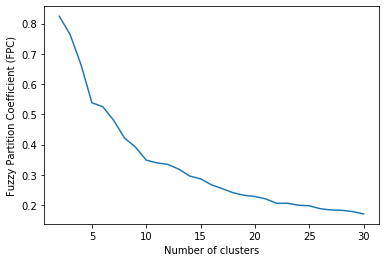

In [24]:
# Plot fpc Graph
plt.plot(range(c_min, c_max+1), fpcArr)
plt.xlabel('Number of clusters')
plt.ylabel('Fuzzy Partition Coefficient (FPC)')
plt.show()

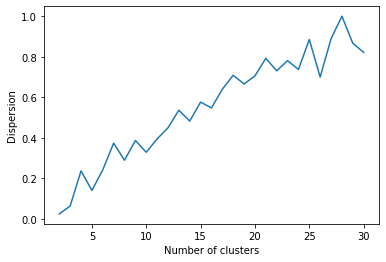

In [25]:
plt.plot(range(2, 31), dispersion_row_normalized)
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion')
plt.show()

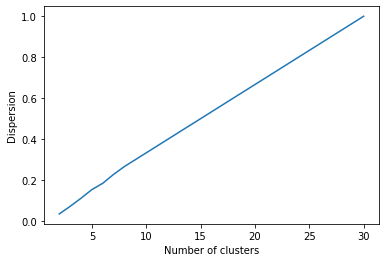

In [27]:
plt.plot(range(2, 31), overlap_row_normalized)
plt.xlabel('Number of clusters')
plt.ylabel('Overlapping')
plt.show()

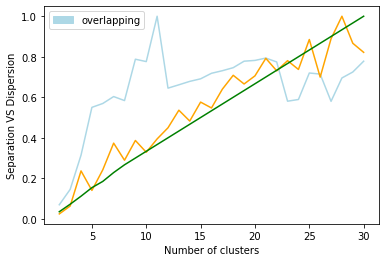

In [51]:
plt.plot(range(2, 31), separation_row_normalized, color='lightblue')
plt.plot(range(2, 31), dispersion_row_normalized, color='orange')
plt.plot(range(2, 31), overlap_row_normalized, color='green')

plt.xlabel('Number of clusters')
plt.ylabel('Separation VS Dispersion')
plt.show()

In [30]:
print("Best Cluster (fpc): " + str(best_cluster))

Best Cluster (fpc): 5
